**Part 3 - Looseness prediction**

Paulo Yoshio Kuga

In [165]:
import pandas as pd
import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

import re
import ast



from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report


*1. Extract features that might be relevant for distinguishing between a healthy and loose asset. Plot the features from the dataset using any data visualization you find relevant.*

First, we load the metadata, and using it, we can load the real data. Metadata provides a dictionary that can be used. To do this, we can associate the original channel to the same nomenclature of the dictionary. 

In [83]:
path = './part_3/'

metadata = pd.read_csv(path + 'part_3_metadata.csv')

dictChannel = {'Ch1 Y-Axis': 'axisX', 'Ch2 Y-Axis': 'axisY','Ch3 Y-Axis': 'axisZ','X-Axis':"time"}

dataDict = {sample_id: pd.read_csv(path + "data/" + sample_id + ".csv") for sample_id in metadata["sample_id"]}

for i,file in metadata.iterrows():
    data = dataDict[file["sample_id"]]
    data.set_index("X-Axis", inplace=True)
    dictOrientation = ast.literal_eval(file["orientation"]) #the original string of the orientation becomes a dictionary
    data.columns = [dictOrientation[dictChannel[name]] for name in data.columns]

    

From previous exercises we can write a function GenerateWelch that returns the three power densities from the provided signals.

In [130]:
#calculates three axis spectral densities

def GenerateWelch(data,nperseg = 1024, overlap_factor = 0.75, windowP="hann" ):

    nover = int(nperseg*overlap_factor)

    data = data - data.mean() #centers the data
   
    fs = data.shape[0] / data.index.max() 

    f, Ph = signal.welch(data["horizontal"].to_numpy(), fs=fs, window=windowP, nperseg=nperseg, noverlap=nover, scaling='density',average='median')
    _, Pv = signal.welch(data["vertical"].to_numpy(), fs=fs, window=windowP, nperseg=nperseg, noverlap=nover, scaling='density',average='median')
    _, Pa = signal.welch(data["axial"].to_numpy(), fs=fs, window=windowP, nperseg=nperseg, noverlap=nover, scaling='density',average='median')

    return f, Ph, Pv, Pa

Than, it is possible to start the development of our features. It is known that structural looseness might lead to a increase of harmonic frequencies. Therefore, in a generic way, this might be seen through  spectral density. Therefore, we can plot the three densities. 

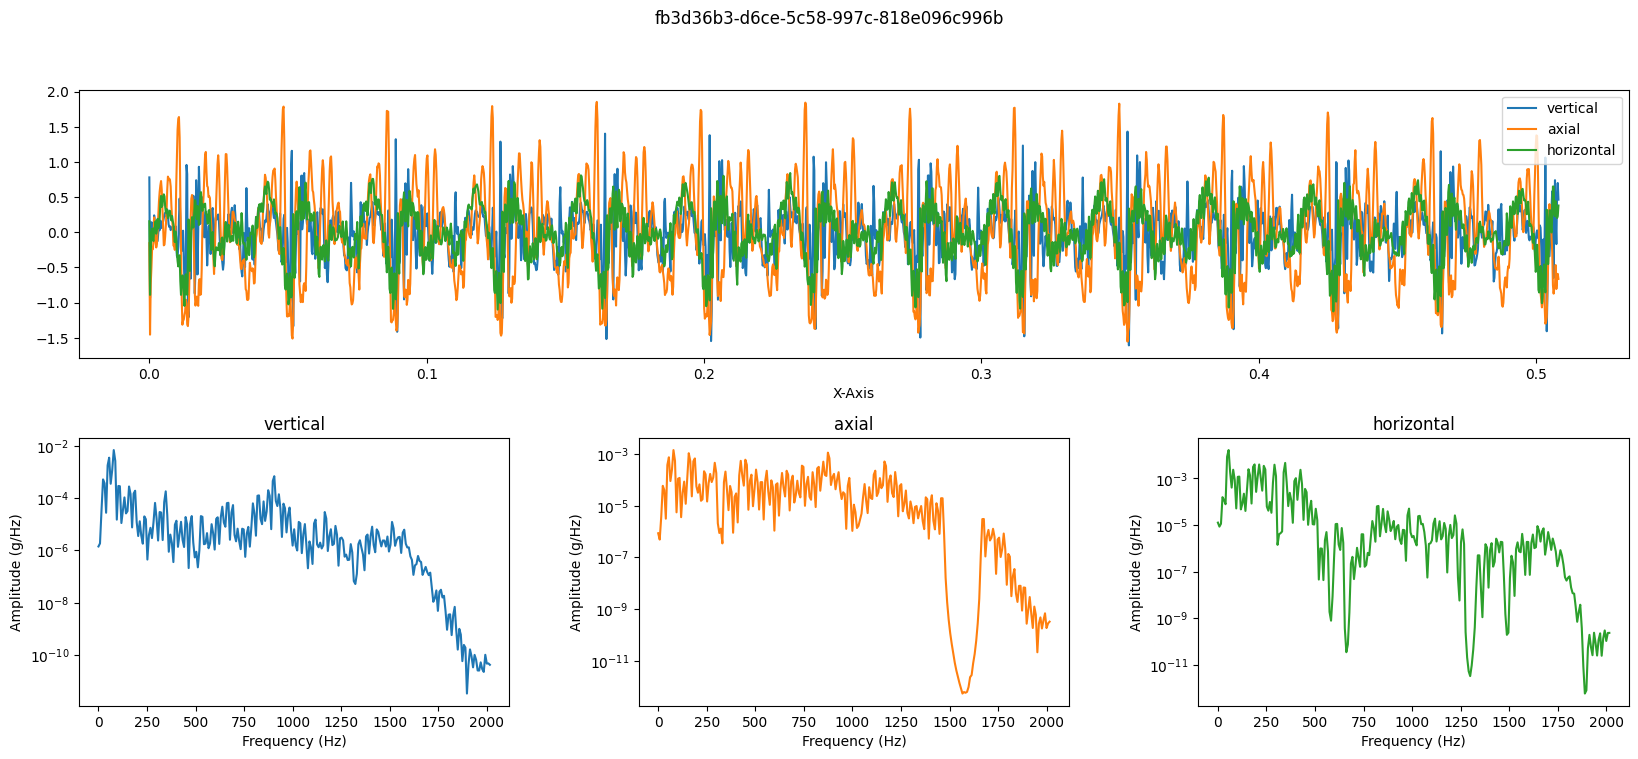

In [189]:
i = 1
w = 512
data = dataDict[metadata["sample_id"][i]]

f,Ph, Pv, Pa  = GenerateWelch(data,nperseg=w,overlap_factor=0.5)
P_g = np.array([Ph, Pv, Pa])

# fig, axs = plt.subplots(1, 3, figsize=(30, 7))
# for j, ax in enumerate(axs):
#     ax.semilogy(f, P_g[j], color='C'+str(j))
#     ax.set_title(metadata["condition"][i] + " - " + data.columns[j])
#     ax.set_xlabel('Frequency (Hz)')
#     ax.set_ylabel('Amplitude (g/Hz)')

fig = plt.figure(figsize=(20, 8))
gs = GridSpec(2, 3, figure=fig, height_ratios=[1, 1], width_ratios=[1,1,1], hspace=0.3, wspace=0.3)

fig.suptitle(metadata["sample_id"][i])

ax = fig.add_subplot(gs[0, :])
data.plot(ax=ax)

for j in range(0,3):
    ax = fig.add_subplot(gs[1, j])
    ax.semilogy(f, P_g[j], color='C'+str(j))
    ax.set_title(data.columns[j])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Amplitude (g/Hz)')

Through trial and error, the percentual energy feature of the spectrum was developed. Generally speaking, in a three-dimensional plane, the integral of the spectrum is expected to reveal something about failure, since, considering that harmonics are multiplied in a looseness situation, the integral of a sample with loosening will be greater than that of one without. 

However, since it is necessary to evaluate several samples, from different machines, for different rotational speeds, it is proposed that this spectrum be normalized using a percentage.

In [86]:
def Percentual(P):
    Ph = np.log10(P)
    return (Ph-Ph.min())/(Ph.max()-Ph.min())

def SampleIntegral(data,nperseg=1024,overlap_factor=0.5):
    f,Ph, Pv, Pa  = GenerateWelch(data,nperseg=nperseg,overlap_factor=overlap_factor)
    P_g = np.array([Percentual(Ph), Percentual(Pa), Percentual(Pv)])
    return np.sum(P_g*(f[1]-f[0]),axis=1)

print("Sample Integral: " + str(SampleIntegral(data)))

Sample Integral: [1181.71599871 1211.07802614 1101.13364272]


Then, it is possible to run this metric to all samples. get_integrals function gets the sample_id and calculates the percentual integral. Then, in a general way, we want to see if the metric can reveal some insight about the condition. 

In the provided plot it is possible to notice that it is possible to evaluate a region that separates between a structural looseness situation and a healthy one. 

Text(0.5, 0.92, ' ')

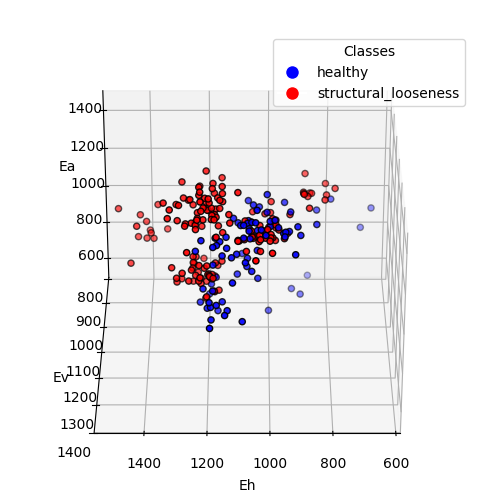

In [133]:
def get_integrals(sample_id):
    return pd.Series(SampleIntegral(dataDict[sample_id]), index=["Eh","Ev","Ea"])

metadata[["Eh","Ev","Ea"]] = metadata["sample_id"].apply(get_integrals)

X = metadata[["Eh","Ev","Ea"]] #our input
y = metadata["condition"] #our desired output

fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111, projection="3d")

colors = {"healthy": "blue", "structural_looseness": "red"}
ax.scatter(metadata["Eh"], metadata["Ev"], metadata["Ea"],
           c=[colors[label] for label in y],
           marker="o", s=20, edgecolor="k")

legend_elements = [Line2D([0], [0], marker='o', color='w', label=key,
                          markerfacecolor=val, markersize=10)
                   for key, val in colors.items()]

ax.legend(handles=legend_elements, title="Classes")

ax.set_xlabel("Eh")
ax.set_ylabel("Ev")
ax.set_zlabel("Ea")
ax.view_init(elev=30, azim=90)
ax.set_title(f" ")


2. Develop a model that distinguishes between healthy and loose assets, and use it to predict the condition of the unlabeled samples. Requirements:

    a. The model must be implemented according to the following Python template. You must use the classes provided to represent the data.

    b. The output is a boolean, where True means there is structural looseness. 

    c. The model must receive the waveforms corresponding to the horizontal, vertical and axial directions as input.

    d. The model can use a baseline condition if you think it is needed. However, this is not mandatory.

    e. You can use any method you find relevant (Machine Learning, Rule-based Logic, etc.), as long as you solve the problem and follow the template.

    f. [BONUS] Implement the score method that quantifies the looseness symptom with a float between 0 and 1, where 0 means no symptom, 1 means very strong symptoms, and any value in between is proportional to
    the strength of the symptoms.

Firstly, we can separate our data between train and test, with the first split to train the model, and later one to check our metrics model and provide a classification report of metrics, such as precision, recall and F1 score. This can lead us to a better understanding of our model performance. 

In [134]:
#stratify parameter can split into test and train with similar class proportion 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=199712115) # a random state is provided just for reproductibility.

The first model to be tested is Support Vector Machine (SVM). SVMs can separate multiple class into plans, providing a robust way to classify samples. 

We can run a GridSearch to find the best parameters for the train samples, and later, we can score using the test samples.

In [135]:

SVMPipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(random_state=19971215))
])

param_grid = {
    'svm__loss': ['hinge', 'log_loss', 'modified_huber'],   # loss function
    'svm__alpha': [0.0001, 0.001, 0.01],              # regularization
    'svm__max_iter': [1000, 2000],
    'svm__penalty': ['l2', 'l1', 'elasticnet']       # penalty 
}

#validation with crossfold 
grid = GridSearchCV(SVMPipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1) #cv parameter is cross validation. literature suggests the using of 5 or 10
grid.fit(X_train, y_train)

#best model
SVMPipe.set_params(**grid.best_params_)

print("Parameters:", grid.best_params_)

SVMPipe.fit(X_train,y_train)

y_hat = SVMPipe.predict(X_test)

print(classification_report(y_test, y_hat))

Parameters: {'svm__alpha': 0.01, 'svm__loss': 'log_loss', 'svm__max_iter': 1000, 'svm__penalty': 'l2'}
                      precision    recall  f1-score   support

             healthy       0.60      0.45      0.51        20
structural_looseness       0.77      0.86      0.81        43

            accuracy                           0.73        63
           macro avg       0.69      0.66      0.66        63
        weighted avg       0.72      0.73      0.72        63



SVM assumption to separate regions is a plan. But what if the region is not exactly a plan? We can test K-Near Neighbors (K-NN) to check if this model can perform better. 

However, it might have a chance of K-NN to overfit, since it references are related to neighbors samples, not necessarily to an general overview of all samples. 

In [136]:
pipeToKnn = Pipeline(    
    steps=[
        ("scaler", StandardScaler()), 
        ("knn", KNeighborsClassifier()
         )
         ]
)


#parameters to be tested
param_grid = {
    "knn__n_neighbors": np.array(list(range(1, 30))),  
    "knn__weights": ["uniform", "distance"]
}

# otimization with cross validation
grid = GridSearchCV(
    pipeToKnn,
    param_grid,
    cv=5, #10 fold had not changed f1                 
    scoring="f1_macro" #macro or weighted?
)

grid.fit(X_train, y_train)

pipeToKnn.set_params(**grid.best_params_)

print("Parameters:", grid.best_params_)

pipeToKnn.fit(X_train,y_train)

y_hat = pipeToKnn.predict(X_test)

#how to score: pipeToKnn.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_hat))

Parameters: {'knn__n_neighbors': 6, 'knn__weights': 'uniform'}
                      precision    recall  f1-score   support

             healthy       0.76      0.80      0.78        20
structural_looseness       0.90      0.88      0.89        43

            accuracy                           0.86        63
           macro avg       0.83      0.84      0.84        63
        weighted avg       0.86      0.86      0.86        63



Indeed, K-NN performed better than SVM. Then, we can construct our classes, including the Loosening Model. It is possible to notice that as wave it is just a list, we need to assure a consistency with the model. Therefore, Waves are converted to DataFrames into predict and score.

The score is obtained through the probability of being "structural_looseness" class. 

In [160]:
from pydantic import BaseModel, Field
from typing import List
class Wave(BaseModel):
    time: List[float] = Field(..., description="Time points of the wave")
    signal: List[float] = Field(..., description="Signal values")

    
class LoosenessModel:
    def __init__(self, **params):
        # Store hyperparameters if needed

        frequencyParams = {"windowP":"hann",
                         "nperseg":512,
                         "noverlap":256
                         }
        
        modelParams = {"n_neighbors":6,
                     "weights":"uniform"}
    
        self.params = {**frequencyParams, **modelParams, **params}
        
        self.Model = Pipeline(    
            steps=[
                ("scaler", StandardScaler()), 
                ("knn", KNeighborsClassifier(n_neighbors=self.params["n_neighbors"],weights=self.params["weights"])
                )
                ]
        )

         #svmParams = {'alpha': 0.0001, 'loss': 'modified_huber', 'max_iter': 1000, 'penalty': 'l2'}

        # self.Model = Pipeline(
        #     steps=[
        #         ('scaler', StandardScaler()),
        #         ('svm', SGDClassifier(
        #             alpha=self.params["alpha"],
        #             loss=self.params["loss"],
        #             max_iter = self.params["max_iter"],
        #             penalty = self.params["penalty"],
        #             ))
        #         ])
        
        #calculates three axis spectral densities
    def GenerateWelch(self,data):
        data = data - data.mean() #centers the data
        fs = data.shape[0] / data.index.max() 

        f, Ph = signal.welch(data["horizontal"].to_numpy(), fs=fs, window=self.params["windowP"], nperseg=self.params["nperseg"], noverlap=self.params["noverlap"], scaling='density',average='median')
        _, Pv = signal.welch(data["vertical"].to_numpy(), fs=fs, window=self.params["windowP"], nperseg=self.params["nperseg"], noverlap=self.params["noverlap"], scaling='density',average='median')
        _, Pa = signal.welch(data["axial"].to_numpy(), fs=fs, window=self.params["windowP"], nperseg=self.params["nperseg"], noverlap=self.params["noverlap"], scaling='density',average='median')

        return f, Ph, Pv, Pa
    
    #returns the log percentual of a spectral density
    def _Percentual(self,P):
        Ph = np.log10(P)
        return (Ph-Ph.min())/(Ph.max()-Ph.min())

    #calculates the percentual integral as feature and set as variable in model
    def _IntegralGen(self, wave_hor: Wave, wave_ver: Wave, wave_axi: Wave):

        data = pd.DataFrame(np.array([wave_hor.signal,wave_ver.signal,wave_axi.signal]).T,index=wave_hor.time,columns=["horizontal","vertical","axial"])
        

        f,Ph, Pv, Pa  = self.GenerateWelch(data)
        self.P_g = np.array([Ph, Pv, Pa])

        P_g = np.array([Percentual(Ph), Percentual(Pa), Percentual(Pv)])
        self.Energy = np.sum(P_g*(f[1]-f[0]),axis=1)

    #it is expected that the X_train and y_train dataset are in a more common data class. 
    def fit(self,X_train, y_train):      
        self.Model.fit(X_train, y_train)

    def predict(self, wave_hor: Wave, wave_ver: Wave, wave_axi: Wave) -> bool:

        """
        Predicts the presence of structural looseness based on horizontal,
        vertical, and axial wave data.
        Args:
        wave_hor (Wave): Horizontal wave data
        wave_ver (Wave): Vertical wave data
        wave_axi (Wave): Axial wave data
        Returns:
        bool: True if looseness is detected, False otherwise
        """

        self._IntegralGen(wave_hor, wave_ver, wave_axi)
        Adequation = pd.DataFrame(self.Energy.reshape(1,-1),columns=["Eh","Ev","Ea"]) #this reshape brings the array to a line of a table

        prediction = self.Model.predict(Adequation)[0] == 'structural_looseness' #zero stands for the fact that the output is a scalar into a array structure 

        return prediction
               
        
    def score(self, wave_hor: Wave, wave_ver: Wave, wave_axi: Wave) -> float:
        """
        Computes a confidence score (between 0 and 1) representing the
        likelihood of structural looseness. This is optional.
        Args:
        wave_hor (Wave): Horizontal wave data
        wave_ver (Wave): Vertical wave data
        wave_axi (Wave): Axial wave data
        Returns:
        float: score (0 = no looseness, 1 = high confidence of looseness)
        """
        self._IntegralGen(wave_hor, wave_ver, wave_axi)

        Adequation = pd.DataFrame(self.Energy.reshape(1,-1),columns=["Eh","Ev","Ea"]) #this reshape brings the array to a line of a table

        
        
        return self.Model.predict_proba(Adequation)[:,1][0] #sklearn defines the order of string classes through alphabetical order, but a structure such as [:,self.Model.classes_ == "structural_looseness"] would solve the problem as well.

Using the content from test_data:

3. Run your model on each sample and predict its condition (loose or healthy). Compute the score for each sample (if implemented) and display the results in a table format.

We can load all test data, in the same way that we did for training data. 

In [163]:
test_metadata = pd.read_csv(path+"test_metadata.csv")
testDataDict = {sample_id: pd.read_csv(path + "test_data/" + sample_id + ".csv") for sample_id in test_metadata["sample_id"]}


dictTestChannel = {'x': 'axisX', 'y': 'axisY','z': 'axisZ','t':"time"}

for i,file in test_metadata.iterrows():
    data = testDataDict[file["sample_id"]]
    data.set_index("t", inplace=True)
    dictOrientation = ast.literal_eval(file["orientation"])
    data.columns = [dictOrientation[dictTestChannel[name]] for name in data.columns]




Finally, we can predict and score for the model, leading to the desired table. 

In [164]:
loosenessModel = LoosenessModel()
loosenessModel.fit(X,y)

'''
Set of functions to deal with conversions between DataFrame and Wave classes
'''

#converts a dataframe into a tuple of waves
def WaveConverter(data):
    t = data.index
    return Wave(time=t, signal = data["horizontal"]), Wave(time=t, signal = data["vertical"]), Wave(time=t, signal = data["axial"])

#predict for a sample_id
def modelPrediction(sample_id):
    Wh, Wv, Wa = WaveConverter(testDataDict[sample_id])
    return loosenessModel.predict(Wh,Wv,Wa)

#scores for a sample_id
def modelScore(sample_id):
    Wh, Wv, Wa = WaveConverter(testDataDict[sample_id])
    return loosenessModel.score(Wh,Wv,Wa)

test_metadata["prediction"] = test_metadata["sample_id"].apply(modelPrediction)
test_metadata["score"] = test_metadata["sample_id"].apply(modelScore)

test_metadata



,asset,sample_id,rpm,orientation,prediction,score
0,electric-motor,33542920-30ea-5844-861d-2c82d79087b8,1170,"{'axisX': 'vertical', 'axisY': 'horizontal', '...",True,0.833333
1,spindle,e057600e-3b4e-58ba-b8b8-357169ae6bf6,1800,"{'axisX': 'horizontal', 'axisY': 'axial', 'axi...",False,0.333333
2,bearing,01e98ad9-23c9-5986-ace0-4519bad71198,1785,"{'axisX': 'horizontal', 'axisY': 'axial', 'axi...",True,0.833333
3,fan,2211750b-6672-5a94-bd40-cda811f69d01,2025,"{'axisX': 'horizontal', 'axisY': 'axial', 'axi...",True,0.833333
4,compressor,680bbcbf-b1c8-544d-8f80-bf763cdcd128,3573,"{'axisX': 'vertical', 'axisY': 'axial', 'axisZ...",True,0.833333
5,compressor,1dab1534-b8a8-5962-b01c-bff0782d54a9,3545,"{'axisX': 'vertical', 'axisY': 'axial', 'axisZ...",True,1.000000
6,bearing,9f3b933a-1bc3-5093-9dee-800cc03c6b1d,1590,"{'axisX': 'horizontal', 'axisY': 'axial', 'axi...",True,0.833333


4. Plot any information you find relevant about each sample (spectrum, waveform, features, etc.).

This script generates the spectral density and plots the waveform and each wave spectrum.

In [187]:
for i,samples in test_metadata.iterrows():
    w = 512
    data = testDataDict[samples["sample_id"]]

    f,Ph, Pv, Pa  = GenerateWelch(data,nperseg=w,overlap_factor=0.5)
    P_g = np.array([Ph, Pv, Pa])

    fig = plt.figure(figsize=(20, 8))
    gs = GridSpec(2, 3, figure=fig, height_ratios=[1, 1], width_ratios=[1,1,1], hspace=0.3, wspace=0.3)

    ax = fig.add_subplot(gs[0, :])
    data.plot(ax=ax)
    ax.legend(loc='upper left',bbox_to_anchor=(1, 1))


    for j in range(0,3):
        ax = fig.add_subplot(gs[1, j])
        ax.semilogy(f, P_g[j], color='C'+str(j))
        ax.set_title(data.columns[j])
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Amplitude (g/Hz)')
    
    fig.savefig("./plots_part3/"+samples["sample_id"])
    fig.suptitle(samples["sample_id"])

    plt.close()
